## SpaRTaNS Tutorial: Double Chamber Flow
#### Last updated: 04/30/2022

## Material Properties

#### Source Code

In [1]:
projectionOperator[vector_]:=IdentityMatrix[Length[vector]]-KroneckerProduct[vector,vector]

meanLifetime[sMC_]:=Mean[1/divideByZeroGivesZero[Diagonal[sMC]]]
divideByZeroGivesZero=Chop[#]/. 0|0. ->\[Infinity]&;
numberOfStates=48;

In [5]:
Clear[isotropicScatteringMatricesSymmetric2D]
isotropicScatteringMatricesSymmetric2D[n_] := 
Block[{angles, velocityProjection, normalizedEnergy, 
   energyProjection, kpts, vels, sm, smVelocityRelaxed,smVelocityProjected},
  
  kpts = N[AngleVector /@ Most[Subdivide[\[Pi]/n, 2 \[Pi] + \[Pi]/n, n]]];
  vels = N[AngleVector /@ Most[Subdivide[\[Pi]/n, 2 \[Pi] + \[Pi]/n, n]]];
  
  velocityProjection = Dot @@ projectionOperator /@ 
     Orthogonalize[Prepend[Transpose[vels], ConstantArray[1, n]], Method -> "GramSchmidt"];
  normalizedEnergy = ConstantArray[1/Sqrt[n], n];
  energyProjection = projectionOperator[normalizedEnergy];
  
  sm = Normal[SparseArray[{i_, i_} :> n - 1., {n, n}, -1.]/n];
  
  smVelocityRelaxed = energyProjection.DiagonalMatrix[Diagonal[sm]].energyProjection;
  smVelocityProjected = velocityProjection.sm.velocityProjection;
  
  {kpts, vels, sm, smVelocityProjected, smVelocityRelaxed}
  ]

scaledIsotropicScatteringMatrix2D[m_][{\[Tau]MC_, \[Infinity]}] := 
 Block[{kpts, vels, numeric, sMC, sMR, \[Beta], \[Alpha]},
  {kpts, vels, numeric, sMC, sMR} = isotropicScatteringMatricesSymmetric2D[m];
  \[Alpha] = 1/\[Tau]MC  meanLifetime[sMC];
  {kpts, vels, numeric, sMC, sMR, \[Alpha] sMC}
  ]

#### Material Properties

- We will consider a 2D isotropic material (SO2)
  - Using a 48 states discretization
- We will consider a material in the "Hydrodynamic" Regime
  - $l_{\mathrm{MC}}/W \approx 0.2$
  - $l_{\mathrm{MR}}/W \rightarrow \infty$
- The group velocities and scattering matrix are plotted below

-Graphics-   Legended[-Graphics-, Placed[-Image-, After, Identity]]
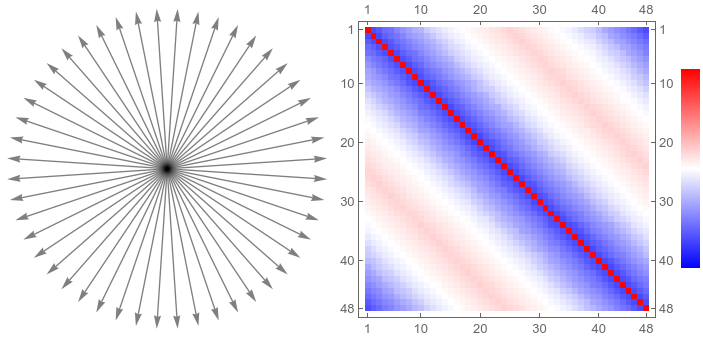

In [8]:
{kpts["SO2"],vels["SO2"],numeric["SO2"],smMomentumConserving["SO2"],smMomentumRelaxing["SO2"],sm["SO2"]}=scaledIsotropicScatteringMatrix2D[numberOfStates][{100,\[Infinity]}];

With[{cf=(Blend[{Blue,White,Red},#]&)},
Multicolumn[{Graphics[{{Opacity[0.5],Arrow[{{0,0},#}]&/@vels["SO2"]}},ImageSize->250],
MatrixPlot[sm["SO2"],PlotLegends->LinearGradientImage[{Bottom,Top}->cf,{30,300}],ImageSize->250,ColorFunction->cf]
},2]]

- We split the scattering matrix into diagonal and mixing-matrix components

In [10]:
diagonal["SO2"] = Diagonal[sm["SO2"]];
mixingMatrix["SO2"] = sm["SO2"] - DiagonalMatrix[diagonal["SO2"]];

- Since all states are on the Fermi surface, we set the energies to the same value of 1 

In [12]:
frequencies["SO2"] = ConstantArray[1., numberOfStates];

- Finally, we pad the 2D velocities with zeros for the out-of-plane direction

In [13]:
velocities["SO2"] = ArrayPad[vels["SO2"], {{0, 0}, {0, 1}}] // N;

## Mesh Properties

#### Source Code

In [14]:
Needs["NDSolve`FEM`"]

visualizeMesh[mesh_] := 
 With[{n = Length[mesh["BoundaryElementMarkerUnion"]]},
  Echo[ColorData["BrightBands"] /@ Rest[Subdivide[n]]];
  mesh["Wireframe"[
    "MeshElementStyle" -> 
     Directive @@@ 
      Thread[{FaceForm@*ColorData["BrightBands"] /@ 
         Rest[Subdivide[n]], EdgeForm[None]}],
    Lighting -> "Neutral",
    Axes -> True, Boxed -> True, AxesLabel -> {"x", "y", "z"}]]
  ]
  
splitLine[{point1_, point2_}, zBottom_ : -25., zMiddle_ : -0., zTop_ : 25.] :=
 Block[{pt1, pt2},
  {pt1, pt2} = SortBy[{point1, point2}, First];
  {
   {Append[pt1, zBottom], Append[pt2, zBottom], 
    Append[pt1, zMiddle]},
   {Append[pt1, zMiddle], Append[pt2, zMiddle], 
    Append[pt2, zBottom]},
   {Append[pt1, zMiddle], Append[pt2, zMiddle], Append[pt1, zTop]},
   {Append[pt1, zTop], Append[pt2, zTop], Append[pt2, zMiddle]}
   }
  ]

#### Mesh Properties

- Manual Boundary Mesh
  - First, define the 2D boundary mesh

-Graphics-
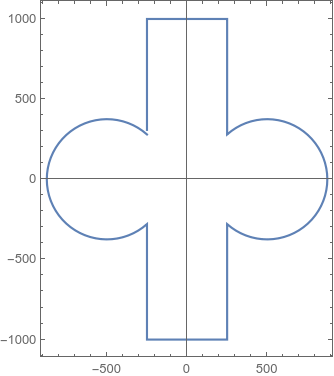

In [18]:
leftChamberChannelIntersection = {x, y} /. FindInstance[
    {x, y} \[Element] 
      Circle[{-500, 0}, 375] &&
     {x, y} \[Element] 
      Line[{{-250, -1000}, {-250, 1000}}]
    , {x, y}, 2];

intersectionAngle = ArcTan @@ (leftChamberChannelIntersection[[2]] - {-500, 0});
leftChamberBoundaryPoints = TranslationTransform[{-500, 0}]@*ScalingTransform[{375, 375}]@*
    AngleVector /@ Subdivide[intersectionAngle, 2 \[Pi] - intersectionAngle, 50];
rightChamberBoundaryPoints = ReflectionTransform[{0, 1}]@*ReflectionTransform[{1, 0}]@
   leftChamberBoundaryPoints;

bottomChannelPoints = DeleteDuplicates[
   Join[Thread[{leftChamberChannelIntersection[[1, 1]], 
      Subdivide[leftChamberChannelIntersection[[1, 2]], -1000, 25]}],
    Thread[{Subdivide[leftChamberChannelIntersection[[1,1]],
    -leftChamberChannelIntersection[[1, 1]], 15], -1000}],
    Thread[{-leftChamberChannelIntersection[[1, 1]], 
      Subdivide[-1000, leftChamberChannelIntersection[[1, 2]], 25]}]
    ]
   ];
topChannelPoints = ReflectionTransform[{1, 0}]@*ReflectionTransform[{0, 1}]@
   bottomChannelPoints;

allPoints = DeleteDuplicates[Join @@ {leftChamberBoundaryPoints, bottomChannelPoints, 
     rightChamberBoundaryPoints, topChannelPoints}];
ListLinePlot[allPoints, AspectRatio -> Automatic, ImageSize -> 250, Frame -> True]

- Then, define a 2D element mesh of order 1

In [26]:
bmesh["middle"] = ToBoundaryMesh["Coordinates" -> allPoints, "BoundaryElements" -> {LineElement[Partition[Append[Range[Length[allPoints]], 1], 2, 1]]}];
emesh["middle"] = ToElementMesh[bmesh["middle"], "MeshOrder" -> 1, "MaxCellMeasure" -> {"Length" -> 50}, "SteinerPoints" -> False, AccuracyGoal -> 1];

- And now "extrude" it
  - First, gather all boundary points

In [28]:
coords["middle"] = emesh["middle"]["Coordinates"];
boundaryCoords["middle"] = Extract[coords["middle"], 
   List /@ (Flatten[emesh["middle"]["BoundaryElements"][[1, 1]]] //Union)];
boundaryPts = Join[
   ArrayPad[coords["middle"], {{0, 0}, {0, 1}}, -25.],
   ArrayPad[boundaryCoords["middle"], {{0, 0}, {0, 1}}, 0.],
   ArrayPad[coords["middle"], {{0, 0}, {0, 1}}, 25.]
   ];
boundaryPtsAsc = AssociationThread[boundaryPts -> Range[Length[boundaryPts]]];

   - Surfaces

In [32]:
bottomSurfaceTriangles = ArrayPad[Extract[coords["middle"], List /@ emesh["middle"]["MeshElements"][[1, 1]]], {{0, 0}, {0, 0}, {0, 1}}, -25.];
topSurfaceTriangles = ArrayPad[Extract[coords["middle"], List /@ emesh["middle"]["MeshElements"][[1, 1]]], {{0, 0}, {0, 0}, {0, 1}}, 25.];
sideSurfaceTriangles = Join @@ (splitLine[coords["middle"][[#]]] & /@ emesh["middle"]["BoundaryElements"][[1, 1]]);
allSurfaceTriangles = Join[bottomSurfaceTriangles, sideSurfaceTriangles, topSurfaceTriangles];
allSurfaceTriangleIndices = Lookup[boundaryPtsAsc, #] & /@ allSurfaceTriangles;

  - Putting everything together

ElementMesh[{{-875., 875.}, {-1000., 1000.}, {-25., 25.}}, {TetrahedronElement[<16395>]}]
-Graphics3D-
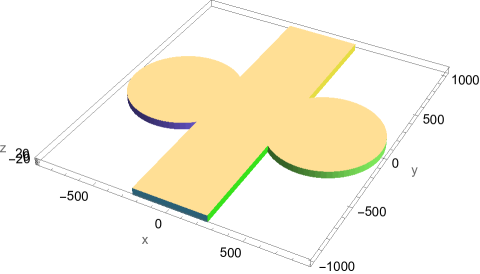

In [37]:
bmesh["SO2"]["double-chamber"] = ToBoundaryMesh["Coordinates" -> boundaryPts, "BoundaryElements" -> {TriangleElement[allSurfaceTriangleIndices]}];
mesh["SO2"]["double-chamber"] =  ToElementMesh[bmesh["SO2"]["double-chamber"], "MeshOrder" -> 1, "MaxCellMeasure" -> {"Length" -> 50}, "SteinerPoints" -> False, AccuracyGoal -> 1]
visualizeMesh[mesh["SO2"]["double-chamber"]]//QuietEcho

## Bounce Properties

- We went through all that trouble above to get a mesh with a one-to-one nodal and triangle correspondence between the periodic surfaces
  - as-well as automatically identified boundary groupings
- Here, we use these to obtain the triangle mapping requested by SpaRTaNS
  - This has the form {outgoing_triangle_index, outgoing_triangle_vertex_index, incoming_triangle_index, incoming_triangle_vertex_index}
    - for each "bounce tensor"

In [40]:
triangles["SO2"]["double-chamber"] = Thread[mesh["SO2"]["double-chamber"]["BoundaryElements"][[1]]] /. TriangleElement[a__] :> List[a];
vertices["SO2"]["double-chamber"] = mesh["SO2"]["double-chamber"]["Coordinates"];
Do[positions["SO2"]["double-chamber"][j] = Flatten[Position[triangles["SO2"]["double-chamber"], {{t1_, t2_, t3_}, i_} /; i == j]], 
    {j, Length[mesh["SO2"]["double-chamber"]["BoundaryElementMarkerUnion"]]}]

- We will use two bounce tensors
  - Identity scattering across the periodic surfaces of the channel
    - i.e. carriers from surface 4 pass straight through to surface 8, and vice-versa

In [43]:
bottomTriangles["SO2"]["double-chamber"] = 
  Extract[vertices["SO2"]["double-chamber"], 
   List /@ triangles["SO2"]["double-chamber"][[
     positions["SO2"]["double-chamber"][4], 1]]];
bottomTrianglesOrdering["SO2"]["double-chamber"] = 
  Ordering /@ bottomTriangles["SO2"]["double-chamber"];
bottomTrianglesMapped["SO2"]["double-chamber"] = 
  MapAt[-# &, bottomTriangles["SO2"]["double-chamber"], {All, All, 2}];
topTriangles["SO2"]["double-chamber"] = 
  Extract[vertices["SO2"]["double-chamber"], 
   List /@ triangles["SO2"]["double-chamber"][[
     positions["SO2"]["double-chamber"][8], 1]]];
topTrianglesOrdering["SO2"]["double-chamber"] = 
  Ordering /@ topTriangles["SO2"]["double-chamber"];

bottomToTopMapping["SO2"]["double-chamber"] = 
  Position[Sort /@ topTriangles["SO2"]["double-chamber"], #][[1, 
     1]] & /@ (Sort /@ bottomTrianglesMapped["SO2"]["double-chamber"]);
bottomToTopMapping["SO2"]["double-chamber"] = 
  Join @@ MapIndexed[
    Table[{positions["SO2"]["double-chamber"][4][[First[#2]]], i[[1]],
        positions["SO2"]["double-chamber"][8][[#1]], i[[2]]}, {i, 
       Thread[{bottomTrianglesOrdering["SO2"]["double-chamber"][[
          First[#2]]], 
         topTrianglesOrdering["SO2"]["double-chamber"][[#1]]}]}] &, 
    bottomToTopMapping["SO2"]["double-chamber"]];
periodicMapping["SO2"]["double-chamber"] = 
  Join[bottomToTopMapping["SO2"]["double-chamber"], 
   Join @@ Reverse[Partition[#, 2]] & /@ 
    bottomToTopMapping["SO2"]["double-chamber"]];

  - diffuse scattering across all other surfaces

In [51]:
diffusiveMapping["SO2"]["double-chamber"] = 
  Flatten[Table[{positions["SO2"]["double-chamber"][i][[n]], t, 
     positions["SO2"]["double-chamber"][i][[n]], 
     t}, {i, {1, 2, 3, 5, 6, 7, 9, 10}}, {n, 
     Length[positions["SO2"]["double-chamber"][i]]}, {t, 3}], 2];

  - Note: Spartans unlike Mathematica uses 0-based indexing

In [52]:
triangleMappings["SO2"][
   "double-chamber"] = {diffusiveMapping["SO2"]["double-chamber"], 
    periodicMapping["SO2"]["double-chamber"]} - 1;

- We then define our bounce tensors

## Injection Properties

- Finally, we define our body and surface injections
  - We'll use surface injections on the channel surfaces to get the current flowing

In [53]:
surfaceInjectionQ["SO2body"]["double-chamber"] = True;
bodyInjectionQ["SO2"]["double-chamber"] = False;

- We will use two bounce tensors
  - Identity scattering across the periodic surfaces of the channel
    - i.e. carriers from surface 4 pass straight through to surface 8, and vice-versa

In [55]:
tetrahedraIndices["SO2"]["double-chamber"] = 
  First[ElementIncidents[
     mesh["SO2"]["double-chamber"]["MeshElements"]]] - 1;
triangleIndices["SO2"]["double-chamber"] = 
  triangles["SO2"]["double-chamber"][[All, 1]] - 1;

surfaceInjection["SO2"]["double-chamber"] = 
  ConstantArray[0., 
   Prepend[Dimensions[triangleIndices["SO2"]["double-chamber"]], 
    numberOfStates]];

surfaceInjection["SO2"]["double-chamber"] = ReplacePart[
   surfaceInjection["SO2"]["double-chamber"],
   Flatten[
    Table[{state, triangle, order} -> 
      Max[velocities["SO2"][[state, 2]], 0.], {state, 
      numberOfStates}, {triangle, 
      positions["SO2"]["double-chamber"][4]}, {order, {1, 2, 3}}], 2]];

surfaceInjection["SO2"]["double-chamber"] = ReplacePart[
   surfaceInjection["SO2"]["double-chamber"],
   Flatten[
    Table[{state, triangle, order} -> 
      Min[velocities["SO2"][[state, 2]], 0.], {state, 
      numberOfStates}, {triangle, 
      positions["SO2"]["double-chamber"][8]}, {order, {1, 2, 3}}], 
    2]];

- We also provide the surface boundary normals

In [60]:
normalsQ["SO2"]["double-chamber"] = True;
normals["SO2"]["double-chamber"] = -First[mesh["SO2"]["double-chamber"]["BoundaryNormals"]];

- And mesh connectivity
  - Note: since this is an isolated geometry, we simply have an interface w/ itself (periodic and diffuse)

In [62]:
connectivity["SO2"]["double-chamber"] = {{1}};

## Injection Properties

- Finally, we define our body and surface injections
  - We'll use surface injections on the channel surfaces to get the current flowing

In [67]:
surfaceInjectionQ["SO2body"]["double-chamber"] = True;
bodyInjectionQ["SO2"]["double-chamber"] = False;

- We will use two bounce tensors
  - Identity scattering across the periodic surfaces of the channel
    - i.e. carriers from surface 4 pass straight through to surface 8, and vice-versa

In [69]:
tetrahedraIndices["SO2"]["double-chamber"] = 
  First[ElementIncidents[
     mesh["SO2"]["double-chamber"]["MeshElements"]]] - 1;
triangleIndices["SO2"]["double-chamber"] = 
  triangles["SO2"]["double-chamber"][[All, 1]] - 1;

surfaceInjection["SO2"]["double-chamber"] = 
  ConstantArray[0., 
   Prepend[Dimensions[triangleIndices["SO2"]["double-chamber"]], 
    numberOfStates]];

surfaceInjection["SO2"]["double-chamber"] = ReplacePart[
   surfaceInjection["SO2"]["double-chamber"],
   Flatten[
    Table[{state, triangle, order} -> 
      Max[velocities["SO2"][[state, 2]], 0.], {state, 
      numberOfStates}, {triangle, 
      positions["SO2"]["double-chamber"][4]}, {order, {1, 2, 3}}], 2]];

surfaceInjection["SO2"]["double-chamber"] = ReplacePart[
   surfaceInjection["SO2"]["double-chamber"],
   Flatten[
    Table[{state, triangle, order} -> 
      Min[velocities["SO2"][[state, 2]], 0.], {state, 
      numberOfStates}, {triangle, 
      positions["SO2"]["double-chamber"][8]}, {order, {1, 2, 3}}], 
    2]];

- We also provide the surface boundary normals

In [75]:
normalsQ["SO2"]["double-chamber"] = True;
normals["SO2"]["double-chamber"] = -First[mesh["SO2"]["double-chamber"]["BoundaryNormals"]];

- And mesh connectivity
  - Note: since this is an isolated geometry, we simply have an interface w/ itself (periodic and diffuse)

In [77]:
connectivity["SO2"]["double-chamber"] = {{1}};bounceTensors["SO2"]["double-chamber"] = {
   ConstantArray[2./numberOfStates, {numberOfStates, numberOfStates}],
   N[IdentityMatrix[numberOfStates]]
   };

## Export Inputs

#### Source Code

In [1]:
Needs["GeneralUtilities`"]
pythonSession = 
  StartExternalSession[<|"System" -> "Python", "Version" -> "3"|>];

SetDirectory[NotebookDirectory[]]

prepareInputs[sym_][geometry_] :=
 <|
  
  "A" -> <|
    
    "velocities" -> NumericArray[velocities[sym], "Real64"],
    "frequencies" -> NumericArray[frequencies[sym], "Real64"],
    "diagonal" -> NumericArray[diagonal[sym], "Real64"],
    "mixing_matrix" -> NumericArray[mixingMatrix[sym], "Real64"]
    |>,
  "000" -> <|
    
    "vertices" -> NumericArray[vertices[sym][geometry], "Real64"],
    "tetrahedra_indices" -> 
     NumericArray[tetrahedraIndices[sym][geometry], "Integer64"],
    "triangle_indices" -> 
     NumericArray[triangleIndices[sym][geometry], "Integer64"],
    If[normalsQ[sym][geometry], 
     "surface_normals" -> 
      NumericArray[normals[sym][geometry], "Real64"], Nothing]
    |>,
  "connectivity_info" -> <|
    
    "connectivity" -> 
     NumericArray[connectivity[sym][geometry], "Integer64"],
    "000--A_000--A" -> 
     Association[
      MapIndexed[
       StringTemplate["bounce_`1`"][
          IntegerString[First[#2] - 1, 10, 2]] -> 
         NumericArray[#1, "Integer64"] &, 
       triangleMappings[sym][geometry]]],
    "bounce_tensors" -> 
     Association[
      MapIndexed[
       StringTemplate["bounce_`1`"][
          IntegerString[First[#2] - 1, 10, 2]] -> 
         NumericArray[#1, "Real64"] &, bounceTensors[sym][geometry]]]
    |>,
  "000--A" -> <|
    
    If[surfaceInjectionQ[sym][geometry], 
     "surface_injection" -> 
      NumericArray[surfaceInjection[sym][geometry], "Real64"], 
     Nothing],
    If[bodyInjectionQ[sym][geometry], 
     "body_injection" -> 
      NumericArray[bodyInjection[sym][geometry], "Real64"], Nothing]
    |>
  |>

exportInputs[sym_][geometry_] := Block[{name, spartansInput},
  
  spartansInput = prepareInputs[sym][geometry];
  name = StringTemplate["spartans_test_`1`_`2`_dataset"][sym, 
    geometry];
  
  ExportStructuredHDF5[name <> ".h5", spartansInput];
  Run[StringTemplate[
     "h5repack -i `1`.h5 -o `1`-compressed.h5 -f GZIP=1"][name]];
  
  ExternalEvaluate[pythonSession, 
   StringTemplate[postProcessing[sym][geometry]][name, Directory[]]];
  
  Run[StringTemplate["rm `1`.h5"][name]]
  ]

- Finally, we export our inputs

In [ ]:
postProcessing["SO2"]["double-chamber"] = "
import h5py
import numpy as np
import os

with h5py.File('`2`/`1`-compressed.h5','a') as f:
    f['000--A'].attrs['material']='A'
    f['000--A'].attrs['mesh']='000'
    f['connectivity_info']['000--A_000--A'].attrs['outgoing_structure'\
]='000--A'
    f['connectivity_info']['000--A_000--A'].attrs['incoming_structure'\
]='000--A'
    f['connectivity_info']['connectivity'].attrs['ordering']=np.array(\
[b'000'])
";

In [ ]:
exportInputs["SO2"]["double-chamber"]

## Visualize Outputs

- Finally, we can visualize the horizontal, vertical current density
  - as well as the current stream plot, illustrating the vortex behavior characteristic of viscous fluids

In [78]:
Directory[]

/home/george/Documents/git-repos/spartans-narang/tutorials/double-chamber-flow/notebooks

-Graphics-   -Graphics-   -Graphics-
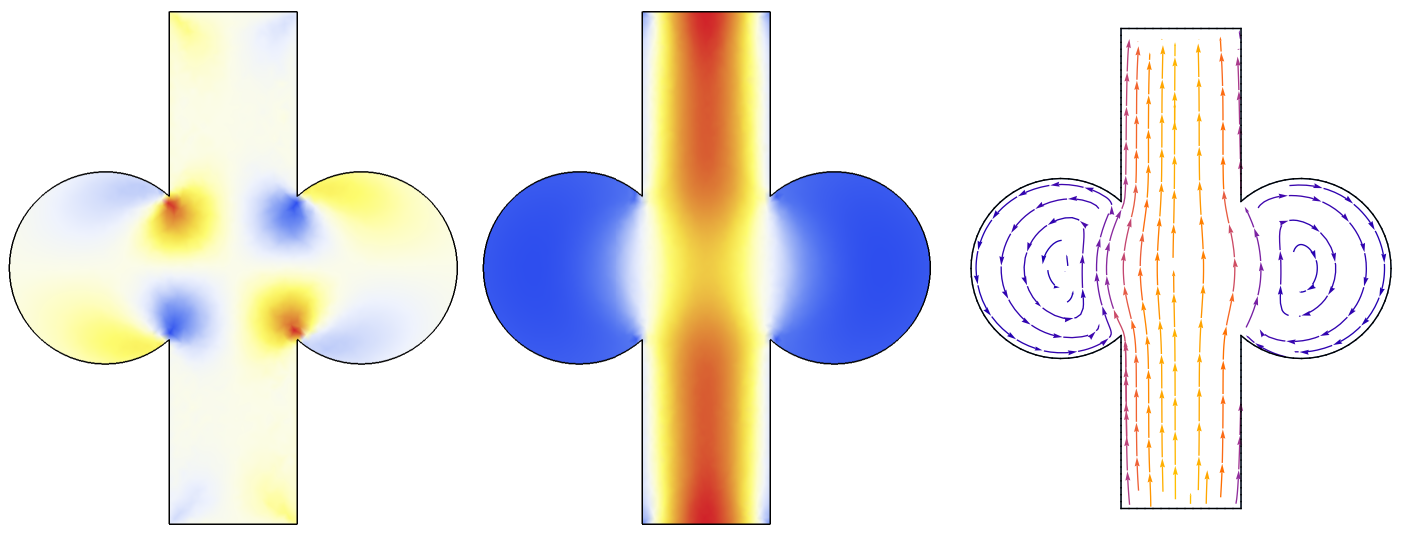

In [79]:
Block[{bOut, horizontalFluxInterpolation, verticalFluxInterpolation, 
  file, sdp, hdp, vdp, streamplot},
 file = FileNameJoin[{FileNameDrop[Directory[],-1], "out-files", 
    "accumulated_000--A.h5"}];
 bOut = Import[file, {"Data", "/Bo_acc"}];
 
 horizontalFluxInterpolation = 
  ElementMeshInterpolation[{mesh["SO2"]["double-chamber"]}, 
   velocities["SO2"][[All, 1]] . bOut, 
   "ExtrapolationHandler" -> {Function[Indeterminate]}];
 
 verticalFluxInterpolation = 
  ElementMeshInterpolation[{mesh["SO2"]["double-chamber"]}, 
   velocities["SO2"][[All, 2]] . bOut, 
   "ExtrapolationHandler" -> {Function[Indeterminate]}];
 
 hdp = Show[
   DensityPlot[
    horizontalFluxInterpolation[x, y, 0], {x, y} \[Element] 
     emesh["middle"], ColorFunction -> "TemperatureMap", 
    Frame -> False, PlotRange -> All, AspectRatio -> Automatic, 
    ImageSize -> 350, PlotPoints -> 50],
   bmesh["middle"]["Wireframe"]
   ];
 
 vdp = Show[
   DensityPlot[
    verticalFluxInterpolation[x, y, 0], {x, y} \[Element] 
     emesh["middle"], ColorFunction -> "TemperatureMap", 
    Frame -> False, PlotRange -> All, AspectRatio -> Automatic, 
    ImageSize -> 350, PlotPoints -> 50],
   bmesh["middle"]["Wireframe"]
   ];
 
 streamplot = 
  Show[StreamPlot[{horizontalFluxInterpolation[x, y, 0], 
     verticalFluxInterpolation[x, y, 0]}, {x, y} \[Element] 
     emesh["middle"], RegionFillingStyle -> None, PlotRange -> All, 
    AspectRatio -> Automatic, ImageSize -> 350, Frame -> False],
   bmesh["middle"]["Wireframe"]
   ];
 
 Multicolumn[{hdp, vdp, streamplot}, 3]
 
 ]